In [72]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from matplotlib_inline import backend_inline
from matplotlib import pyplot as plt
from torch.functional import F
import numpy as np
import pandas as pd
import numba
from numba import jit
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from IPython import display
from pathlib import Path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import os

def check_path_exists(path):
    return os.path.exists(path)

In [73]:
import pandas as pd
data = pd.read_csv('data/train_cleaned.csv')
data.drop(['Unnamed: 0'], axis=1, inplace=True)


In [74]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
def use_svg_display(): 
    backend_inline.set_matplotlib_formats('svg')
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


In [75]:
class AT_LSTM(nn.Module):
    def __init__(self, input_size, num_hiddens, output_size, device):
        super(AT_LSTM, self).__init__()
        self.num_hiddens = num_hiddens
        self.lstm = nn.LSTM(input_size, num_hiddens, batch_first=True)
        self.attention = nn.MultiheadAttention(num_hiddens, 8)
        self.layer_norm1 = nn.LayerNorm(num_hiddens)  # 层正则化
        self.layer_norm2 = nn.LayerNorm(num_hiddens)  # 层正则化
        self.fc = nn.Linear(num_hiddens, output_size)
        self.device = device

    def forward(self, X):
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(1, X.size(0), self.num_hiddens).to(self.device)
        c0 = torch.zeros(1, X.size(0), self.num_hiddens).to(self.device)

        # LSTM 层
        lstm_out, _ = self.lstm(X, (h0, c0))  # [batch_size, seq_length, num_hiddens]

        # 层正则化
        normed_lstm_out = self.layer_norm1(lstm_out)

        # 转置以适应多头注意力的输入要求
        lstm_out_transposed = normed_lstm_out.transpose(0, 1)  # [seq_length, batch_size, num_hiddens]

        # 多头注意力
        attention_out, _ = self.attention(lstm_out_transposed, lstm_out_transposed, lstm_out_transposed)

        # 逆转置
        attention_out_transposed = attention_out.transpose(0, 1)  # [batch_size, seq_length, num_hiddens]

        # 残差连接
        combined_out = attention_out_transposed + normed_lstm_out  # 添加残差连接

        # 第二次层正则化
        normed_combined_out = self.layer_norm2(combined_out)

        # 聚合特征
        aggregated_features = normed_combined_out.sum(dim=1)

        # 全连接层
        output = self.fc(aggregated_features)
        return output


In [76]:
def at_train_epoch(net, train_iter, loss, optimizer, device):
    net.train()
    total_loss = 0
    for X, Y in train_iter:
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        output = net(X)  # 修改这一行以获取输出张量
        l = loss(output, Y)
        l.backward()
        optimizer.step()
        total_loss += l.item()
    return total_loss / len(train_iter)

def at_train(net, train_iter, lr, num_epochs, device):
    loss = nn.L1Loss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = Animator(xlabel='epoch', ylabel='loss', ylim=[3, 15],figsize=(10, 10))

    for epoch in range(num_epochs):
        train_loss = at_train_epoch(net, train_iter, loss, optimizer, device)
        print(f'Epoch {epoch + 1}, Loss: {train_loss:.4f}')
        animator.add(epoch + 1, [train_loss])


In [77]:
features = ['seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 
                'reference_price', 'matched_size', 'far_price', 'near_price', 
                'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap']

In [79]:
def create(group, num_timesteps):
    return np.array([group[i:i + num_timesteps].values for i in range(len(group) - num_timesteps + 1)])

def create_labels(data):
    num_timesteps = 550  # 每个样本的时间步长

    labels_list = []

    # 对于每个stock_id
    for _, group in data.groupby('stock_id'):

        label_samples = create(group[['target']], num_timesteps)
        labels_list.append(label_samples)

    return np.vstack(labels_list)[:,-1,:]

def create_samples(data):
    num_timesteps = 550  # 每个样本的时间步长
    features = ['seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 
                'reference_price', 'matched_size', 'far_price', 'near_price', 
                'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap']

    samples_list = []


    for _, group in data.groupby('stock_id'):
        group = group[features]  # 选择特定特征
        samples = create(group, num_timesteps)
        samples_list.append(samples)
        
    return np.vstack(samples_list)


def process_stock_data(data):
    samples = create_samples(data)
    label_samples = create_labels(data)
    return samples, label_samples

# 模型训练和保存
def train_and_save_model(train_features, train_labels, model, save_path, batch_size=55, lr=0.001, num_epochs=50):
    
    train_dataset = TensorDataset(torch.tensor(train_features, dtype=torch.float32), 
                                  torch.tensor(train_labels, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=batch_size)

    # 训练
    at_train(model, train_loader, lr=lr, num_epochs=num_epochs, device=device)

    # 保存模型
    torch.save(model.state_dict(), save_path)


Epoch 20, Loss: 4.6947


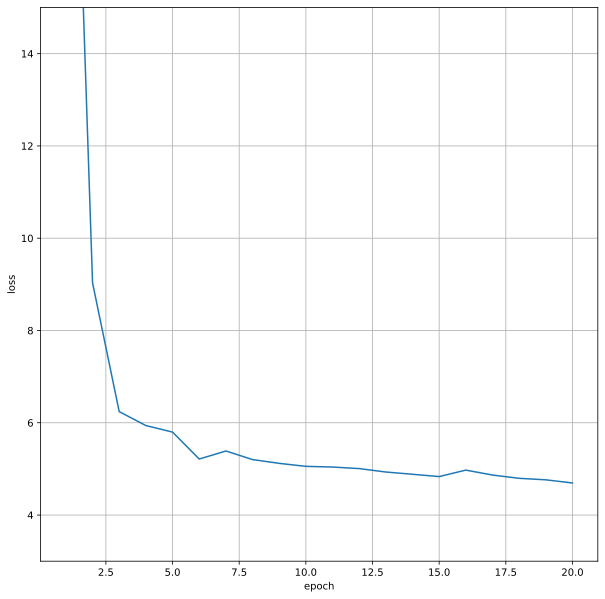

In [80]:
# 初始化模型参数
from sklearn import model_selection


param = {'input_size' : len(features),  
'output_size' : 1,  
'num_hiddens' : 128,
'device' : torch.device('cuda' if torch.cuda.is_available() else 'cpu'),}
model = AT_LSTM(**param).to(device)

# 读取数据
data = pd.read_csv('data/train_cleaned.csv')

# 逐步处理和训练
for stock_id in tqdm(range(0, 199)):  
    if stock_id <= 158:  # 前80%作为训练集
        print(f'Processing stock_id {stock_id}...')
        data_temp = data[data['stock_id']==stock_id]
        samples, label_samples = process_stock_data(data_temp)
        if check_path_exists(path='model_stock.pth'):
            model = model.load_state_dict(torch.load('model_stock.pth'))
        train_and_save_model(samples, label_samples, model, f'model_stock.pth')

        # 清理内存
        del samples, label_samples, data_temp
        torch.cuda.empty_cache()


In [ ]:
train_features.shape

torch.Size([21164, 55, 12])

In [ ]:
inputs, _ = next(iter(train_loader))  # 获取一批数据
outputs, attention_weights = model(inputs.to(device))

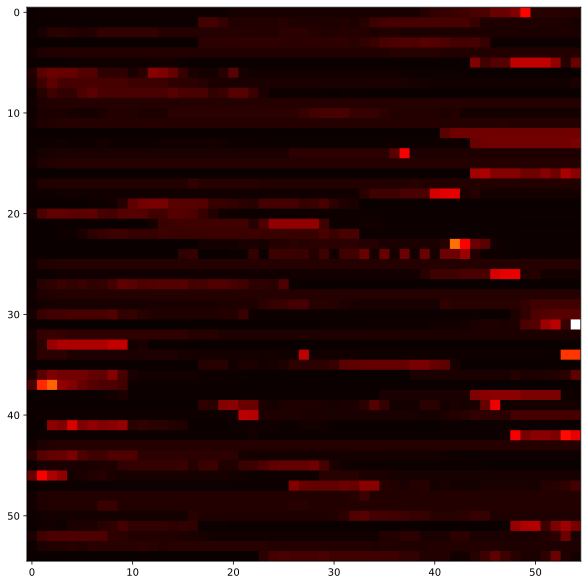

In [ ]:
# 绘制注意力权重矩阵
plt.figure(figsize=(10, 10))
plt.imshow(attention_weights.detach().cpu().numpy(), cmap='hot')
plt.show()

In [ ]:
y_pred = model(X_valid.to(device))[0].detach().cpu().numpy()

In [ ]:
Y_valid.shape

torch.Size([5237, 1])

In [ ]:
Y_valid

tensor([[ 2.6703],
        [ 1.1396],
        [ 0.9406],
        ...,
        [-0.1699],
        [ 3.1102],
        [ 0.7606]])

In [ ]:
y_pred.shape

(5237, 1)

In [ ]:
data[data['stock_id']==0]['time_id'][54:].shape

(26401,)

In [ ]:
x = data[data['stock_id']==0]['time_id'][54:].values

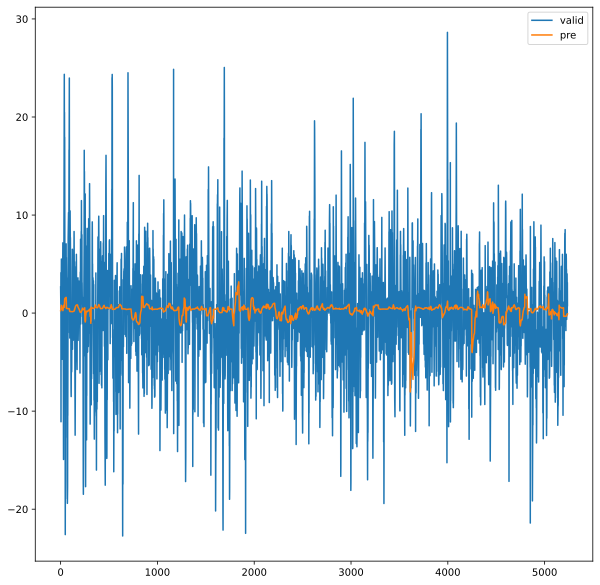

In [ ]:
# draw
plt.figure(figsize=(10, 10))
plt.plot(Y_valid, label='valid')
plt.plot(y_pred, label='pre')
plt.legend()
plt.show()

In [ ]:
# mae 
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(Y_valid, y_pred)

In [ ]:
mae

4.167461